In [1]:
# %load_ext autoreload
# %autoreload 2

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

import time
import os
import sys
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

from data_utils import read_data_sets

torch.set_default_dtype(torch.float32)

sys.path.append("../src")

from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

seed = 13
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [3]:
dataset = read_data_sets("MNIST", "../data/", if_autoencoder=True)

Begin loading data for MNIST
Data read from ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/t10k-images-idx3-ubyte.gz
Data read from ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/train-labels-idx1-ubyte.gz


Extracting ../data/data/MNIST_data/t10k-labels-idx1-ubyte.gz
Succesfully loaded MNIST dataset.


In [4]:
## Dataset
train_dataset = dataset.train
test_dataset = dataset.test

batch_size = 100

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [5]:
model = nn.Sequential(
    nn.Linear(784, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 30, dtype=torch.float32),
    nn.Linear(30, 250, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(250, 500, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(500, 1000, dtype=torch.float32),
    nn.ReLU(),
    nn.Linear(1000, 784, dtype=torch.float32),
)

model = model.to(device)

likelihood = FISH_LIKELIHOODS["bernoulli"](device=device)

In [6]:
model_adam = copy.deepcopy(model)

lr = 0.001
# betas = (0.7, 0.9)
weight_decay = 1e-5
# eps = 1e-8


opt = optim.Adam(
    model.parameters(),
    lr=lr,
    # betas=betas,
    weight_decay=weight_decay,
    # eps=eps,
)

In [7]:
writer = SummaryWriter(
    log_dir=f"runs/MNIST_adam/lr={lr}_lambda={weight_decay}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

epochs = 5

st = time.time()
eval_time = 0

train_losses_adam, test_losses_adam = [], []
clock_time_adam = []


for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model(batch_data)

            loss = likelihood(output, batch_labels)

            running_loss += loss.item()

            loss.backward()
            opt.step()

            et = time.time()
            if n % 50 == 0:
                model.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )
        # Save results
        train_losses_adam.append(running_loss / n)
        test_losses_adam.append(running_test_loss)
        clock_time_adam.append(epoch_time)
        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)


Epoch 5: 100%|██████████| 600/600 [00:07<00:00, 84.19batch/s, loss=82.7, test_loss=90.8] 


In [8]:
model_fl = copy.deepcopy(model)

scale = 1

model_fl = initialise_FishModel(model_fl, module_names="__ALL__", fish_scale=scale)

model_fl = model_fl.to(device)

aux_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size
)

In [9]:
lr = 0.005
beta = 0.3
weight_decay = 1e-5

aux_lr = 1e-4
aux_eps = 1e-8
damping = 0.5
update_aux_every = 10

initialization = "normal"
normalization = True

opt = FishLeg(
    model_fl,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    warmup_steps=0,
    update_aux_every=update_aux_every,
    device=device,
    writer=writer,
)

In [10]:
writer = SummaryWriter(
    log_dir=f"runs/MNIST_fishleg/lr={lr}_lambda={weight_decay}/{datetime.now().strftime('%Y%m%d-%H%M%S')}",
)

epochs = 5

st = time.time()
eval_time = 0

train_losses_fl, test_losses_fl = [], []
clock_time_fl = []

for epoch in range(1, epochs + 1):
    with tqdm(train_loader, unit="batch") as tepoch:
        running_loss = 0
        for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
            tepoch.set_description(f"Epoch {epoch}")

            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            opt.zero_grad()
            output = model_fl(batch_data)

            loss = likelihood(output, batch_labels)

            loss.backward()
            opt.step()

            running_loss += loss.item()

            et = time.time()
            if n % 50 == 0:
                model_fl.eval()

                running_test_loss = 0

                for m, (test_batch_data, test_batch_labels) in enumerate(test_loader):
                    test_batch_data, test_batch_labels = test_batch_data.to(
                        device
                    ), test_batch_labels.to(device)

                    test_output = model_fl(test_batch_data)

                    test_loss = likelihood(test_output, test_batch_labels)

                    running_test_loss += test_loss.item()

                running_test_loss /= m

                tepoch.set_postfix(loss=loss.item(), test_loss=running_test_loss)
                model.train()
                eval_time += time.time() - et

        epoch_time = time.time() - st - eval_time

        tepoch.set_postfix(
            loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time
        )
        # Save results
        train_losses_fl.append(running_loss / n)
        test_losses_fl.append(running_test_loss)
        clock_time_fl.append(epoch_time)
        # Write out the losses per epoch
        writer.add_scalar("Loss/train", running_loss / n, epoch)
        writer.add_scalar("Loss/test", running_test_loss, epoch)

        # Write out the losses per wall clock time
        writer.add_scalar("Loss/train/time", running_loss / n, epoch_time)
        writer.add_scalar("Loss/test/time", running_test_loss, epoch_time)

Epoch 1:   6%|▋         | 38/600 [00:00<00:06, 81.41batch/s]

Epoch 5: 100%|██████████| 600/600 [00:09<00:00, 64.91batch/s, loss=96.9, test_loss=103]


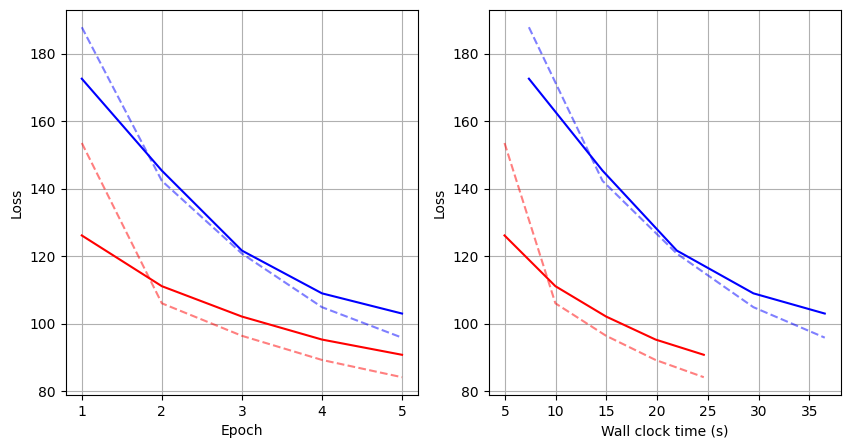

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(range(1, epochs + 1), train_losses_adam, ls="--", color="red", alpha=0.5)
ax[0].plot(range(1, epochs + 1), train_losses_fl, ls="--", color="blue", alpha=0.5)
ax[0].plot(range(1, epochs + 1), test_losses_adam, color="red", alpha=1.0)
ax[0].plot(range(1, epochs + 1), test_losses_fl, color="blue", alpha=1.0)

ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

ax[1].plot(clock_time_adam, train_losses_adam, ls="--", color="red", alpha=0.5)
ax[1].plot(clock_time_fl, train_losses_fl, ls="--", color="blue", alpha=0.5)
ax[1].plot(clock_time_adam, test_losses_adam, color="red", alpha=1.0)
ax[1].plot(clock_time_fl, test_losses_fl, color="blue", alpha=1.0)

ax[1].set_xlabel("Wall clock time (s)")
ax[1].set_ylabel("Loss")
ax[1].grid(True)
plt.show()